# Automatic Detection Of Lumpy Skin Disease Using Deep Learning Techniques

# 🦠 Importing Libraries

In [1]:
# Importing Libraries
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Base Path for all files
data_dir = '../input/lumpyskindiseaseresearch'

# 🦠 Load Images For Training & Testing

In [3]:
###### Using ImageDataGenerator to load the Images for Training and Testing the CNN Model
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='validation',
                                                    ),
}

Found 1238 images belonging to 2 classes.
Found 137 images belonging to 2 classes.


# 🦠 Initialize ResNet50 Pretrained Model

In [6]:
# Initializing InceptionV3 (pretrained) model with input image shape as (300, 300, 3)
base_model = ResNet50(weights=None, include_top=False, input_shape=(256, 256, 3))

# Load Weights for the InceptionV3 Model
base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',by_name=True, skip_mismatch=True)

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False

# 🦠 Add Custom Layer

In [7]:
# Adding some more layers at the end of the Model as per our requirement
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax') # 10 Output Neurons for 10 Classes
])

In [8]:
# Using the Adam Optimizer to set the learning rate of our final model
opt = optimizers.Adam(learning_rate=0.0001)

# Compiling and setting the parameters we want our model to use
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

# 🦠 View Model Summary & Plot


In [9]:
# Viewing the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 25,687,938
Trainable params: 2,100,226
Non-trainable params: 23,587,712
_________________________________________________________________


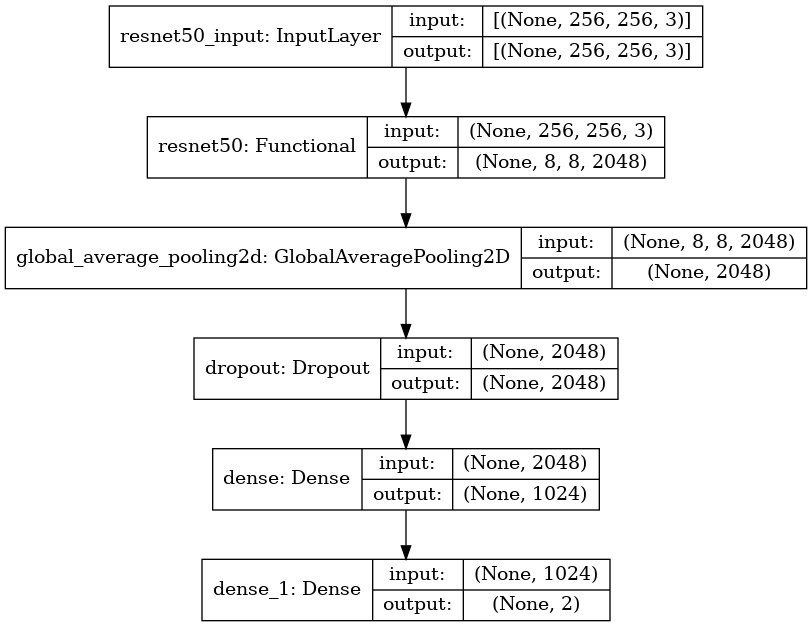

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

# 🦠 Model Building


In [11]:
# Setting variables for the model
batch_size = 32
epochs = 10

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [12]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 38
validation_steps : 4


# 🦠 Model Training


In [13]:
# File Path to store the trained models
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Using the ModelCheckpoint function to train and store all the best models
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]
# Training the Model
history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

2022-09-13 12:41:53.505217: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
38/38 [==============================] - 149s 4s/step - loss: 0.6957 - accuracy: 0.4900 - val_loss: 0.6915 - val_accuracy: 0.5078

Epoch 00001: val_accuracy improved from -inf to 0.50781, saving model to ./model_01-0.51.h5
Epoch 2/10
38/38 [==============================] - 141s 4s/step - loss: 0.6951 - accuracy: 0.5091 - val_loss: 0.6904 - val_accuracy: 0.5703

Epoch 00002: val_accuracy improved from 0.50781 to 0.57031, saving model to ./model_02-0.57.h5
Epoch 3/10
38/38 [==============================] - 141s 4s/step - loss: 0.6923 - accuracy: 0.5008 - val_loss: 0.6888 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 0.57031
Epoch 4/10
38/38 [==============================] - 140s 4s/step - loss: 0.6890 - accuracy: 0.5290 - val_loss: 0.6877 - val_accuracy: 0.6406

Epoch 00004: val_accuracy improved from 0.57031 to 0.64062, saving model to ./model_04-0.64.h5
Epoch 5/10
38/38 [==============================] - 141s 4s/step - loss: 0.6880 - accuracy: 0.5

# 🦠 Model Evaluation


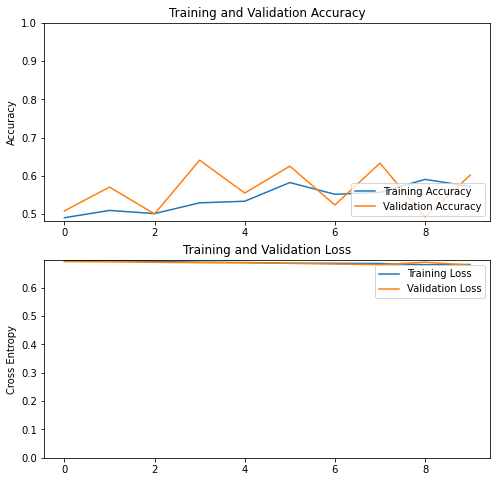

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [15]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

5/5 [==============================] - 14s 3s/step - loss: 0.6777 - accuracy: 0.6058
test accuracy :  0.6058394312858582


In [17]:
# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model("./model_04-0.64.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(256, 256))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = {0: 'Lumpy Skin', 1: 'Normal Skin'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()

# 🦠 Model Testing With Graphs


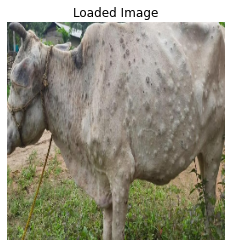



Maximum Probability:  0.5029694
Classified: Lumpy Skin 



-------------------Individual Probability--------------------------------

LUMPY SKIN : 50.3 %
NORMAL SKIN : 49.7 %


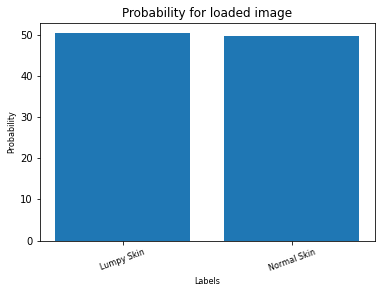

In [18]:
predict("../input/lumpyskindiseaseresearch/Lumpy Skin/LSD-infected_cow_.jpg")

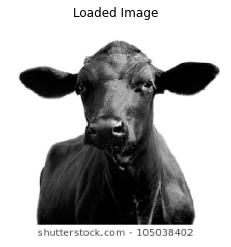



Maximum Probability:  0.5193652
Classified: Normal Skin 



-------------------Individual Probability--------------------------------

LUMPY SKIN : 48.06 %
NORMAL SKIN : 51.94 %


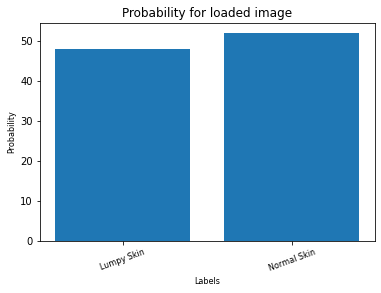

In [19]:
predict("../input/lumpyskindiseaseresearch/Normal Skin/00000032.jpg")

# Thank You

**I will be creating one more notebook showing how to use our model interactively by creating a ML web-app**

**Please feel free to follow me on Kaggle and upvote this Notebook if you found it useful : )**

**📕📕📕 Happy Learning !!! 📕📕📕**